# Final Exam

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import holidays
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [2]:
# Define a function to calculate interest rates from discount factors
def discount_to_intrate(discount, maturity, n_compound=None):

    # If the compounding frequency is not provided, assume continuous compounding
    if n_compound is None:
        # Calculate the continuously compounded interest rate
        intrate = - np.log(discount) / maturity
    else:
        # Calculate the interest rate with discrete compounding
        intrate = n_compound * (1 / discount**(1 / (n_compound * maturity)) - 1)
    
    # Return the computed interest rate
    return intrate

# Convert the Interest/Discount Rate to Discount Factor
def intrate_to_discount(intrate, maturity, n_compound=None):
    # Converts interest rates into discount factors for time value of money calculations.
    # If compounding frequency is not specified, continuous compounding is assumed.
    
    if n_compound is None:
        # Compute the discount factor using the continuous compounding formula:
        # discount = e^(-rate * maturity)
        discount = np.exp(-intrate * maturity)
    else:
        # Compute the discount factor using periodic compounding:
        # discount = 1 / (1 + rate/n_compound)^(n_compound * maturity)
        discount = 1 / (1 + (intrate / n_compound))**(n_compound * maturity)
    
    return discount  # Return the computed discount factor.

def get_coupon_dates(quote_date, maturity_date):
    # Check if quote_date is a string; if yes, convert it to a datetime object
    if isinstance(quote_date, str):
        quote_date = datetime.datetime.strptime(quote_date, '%Y-%m-%d')
        
    # Check if maturity_date is a string; if yes, convert it to a datetime object
    if isinstance(maturity_date, str):
        maturity_date = datetime.datetime.strptime(maturity_date, '%Y-%m-%d')
    
    # Calculate the number of semi-annual periods between quote_date and maturity_date
    # Use ceil to ensure we cover the full period (even if partial)
    num_periods = np.ceil((maturity_date - quote_date).days / 180)
    
    # Generate semi-annual dates going backward from the maturity date
    temp = pd.date_range(
        end=maturity_date, 
        periods=num_periods, 
        freq=pd.DateOffset(months=6)
    )
    
    # Keep only the dates that are after the quote date
    temp = pd.DataFrame(data=temp[temp > quote_date])
    
    # Extract the first column of the DataFrame and return it as the result
    out = temp[0]
    return out


def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):
    # Initialize an empty list to store the benchmark dates
    mask_benchmark_dts = []
    
    # Loop through each column (date) in the cash flow DataFrame
    for col in CF.columns:
        # If filtering by benchmark dates is enabled
        if filter_benchmark_dates:
            # Check if the date is one of the benchmark dates (Feb 15, May 15, Aug 15, Nov 15)
            if col.month in [2, 5, 8, 11] and col.day == 15:
                mask_benchmark_dts.append(col)  # Add it to the list of benchmark dates
        else:
            # If not filtering by benchmark dates, include all dates
            mask_benchmark_dts.append(col)

    # If filtering by maturity dates is enabled
    if filter_maturity_dates:
        # Select columns where at least one cash flow >= 100 (indicating maturity)
        mask_maturity_dts = CF.columns[(CF >= 100).any()]
    else:
        # If not filtering by maturity dates, include all columns
        mask_maturity_dts = CF.columns

    # Combine the two filters: Keep only dates present in both lists
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    # Filter the cash flow DataFrame to include only the selected dates
    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # Strict filtering: Keep only rows where cash flows on included dates match the original cash flows
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]
    else:
        # Lenient filtering: Keep rows with at least one non-zero cash flow on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
    # Remove columns (dates) where all cash flows are zero
    CF_filtered = CF_filtered.loc[:, (CF_filtered > 0).any()]
    
    # Return the filtered cash flow DataFrame
    return CF_filtered


def filter_treasuries(data, t_date=None, filter_maturity = None, filter_maturity_min=None, drop_duplicate_maturities = False, filter_tips=True, filter_yld=True):
    outdata = data.copy()
    
    if t_date is None:
        t_date = outdata['quote date'].values[-1]
    
    outdata = outdata[outdata['quote date']==t_date]
    
    # Filter out redundant maturity
    if drop_duplicate_maturities:
        outdata = outdata.drop_duplicates(subset=['maturity date'])
    
    # Filter by max maturity
    if filter_maturity is not None:
        mask_truncate = outdata['maturity date'] < (t_date + np.timedelta64(365*filter_maturity+1,'D'))
        outdata = outdata[mask_truncate]

    # Filter by min maturity
    if filter_maturity_min is not None:
        mask_truncate = outdata['maturity date'] > (t_date + np.timedelta64(365*filter_maturity_min-1,'D'))
        outdata = outdata[mask_truncate]

    outdata = outdata[outdata['type'].isin([11,12]) == (not filter_tips)]
        
    if filter_yld:
        outdata = outdata[outdata['ytm']>0]
        
    return outdata


def calc_cashflows(quote_data, filter_maturity_dates=False):
    # Create an empty DataFrame to store cash flows
    # Rows represent individual securities (indexed by quote_data.index)
    # Columns represent unique maturity dates from the data
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['maturity date'].unique())

    # Iterate over each security in the dataset
    for i in quote_data.index:
        # Get the semi-annual coupon payment dates for the security
        coupon_dates = get_coupon_dates(quote_data.loc[i, 'quote date'], quote_data.loc[i, 'maturity date'])

        # If coupon dates exist (not None), set coupon payment amounts
        if coupon_dates is not None:
            # Add semi-annual coupon payments (coupon rate divided by 2)
            CF.loc[i, coupon_dates] = quote_data.loc[i, 'cpn rate'] / 2

        # Add the face value (100) at maturity
        CF.loc[i, quote_data.loc[i, 'maturity date']] += 100

    # Replace any NaN values with 0 and sort columns by date
    CF = CF.fillna(0).sort_index(axis=1)
    
    # Remove columns (dates) where all cash flows are zero
    CF.drop(columns=CF.columns[(CF == 0).all()], inplace=True)

    # If filtering by maturity dates is requested, apply the filter function
    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    # Return the final cash flow DataFrame
    return CF


def get_maturity_delta(t_maturity, t_current):
    # Calculates the time-to-maturity in years based on the difference between maturity date and current date.
    # Time is expressed as a fraction of a year (365.25 days to account for leap years).
    
    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')  # Convert timedelta to years.
    
    return maturity_delta  # Return the time-to-maturity in years.

def bootstrap(params, maturity):
    # Extract estimated maturities from the first element of params
    estimated_maturities = params[0]
    # Extract corresponding discount factors (betas) from the second element of params
    betas = params[1]
    # Convert discount factors to interest rates using the discount_to_intrate function
    estimated_rates = discount_to_intrate(betas, estimated_maturities)
    
    # Create an interpolation function for the rates based on maturities
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    # Use the interpolation function to estimate the rate at the given maturity
    rate = f(maturity)
    
    # Return the interpolated rate
    return rate

def price_with_rate_model(params, CF, t_current, fun_model, convert_to_discount=True, price_coupons=False):
    # Prices future cash flows using an interest rate model and optionally converts rates to discount factors.
    
    # Compute the time-to-maturity for all cash flow dates.
    maturity = get_maturity_delta(CF.columns, t_current)
    
    if convert_to_discount:
        # Initialize an array to store discount factors.
        disc = np.zeros(maturity.shape)
        for i, mat in enumerate(maturity):
            # Convert rates (from model) to discount factors using the specified model.
            disc[i] = intrate_to_discount(fun_model(params, mat), mat)
    else:
        # If no discounting is required, use rates directly from the model.
        disc = fun_model(params, maturity)
        
    if price_coupons:
        price = CF * disc
    else:
        # price = cash flow matrix multiply discount factors
        price = CF @ disc
    
    return price

def pricing_errors(params, CF, t_current, fun_model, observed_prices):
    # Computes the difference (error) between observed market prices and model-derived prices.
    # The objective is to minimize this error during model calibration.

    price_modeled = price_with_rate_model(params, CF, t_current, fun_model)  # Get model-derived prices.
    
    if isinstance(observed_prices, (pd.DataFrame, pd.Series)):
        # Convert observed prices to NumPy array if they are in Pandas format.
        observed_prices = observed_prices.values
    
    error = sum((observed_prices - price_modeled)**2)  # Compute the sum of squared differences.
    
    return error  # Return the sum of squared errors.

def nelson_siegel(params, maturity):
    # Nelson-Siegel model is used to fit yield curves with a combination of level, slope, and curvature components.
    # params: [beta_0, beta_1, beta_2, tau], where beta's control curve shape and tau is the decay factor.
    
    rate = (
        params[0] +  # Level component (long-term interest rate).
        (params[1] + params[2]) *  # Combined slope and curvature adjustment.
        (1 - np.exp(-maturity / params[3])) / (maturity / params[3]) -  # Weighted adjustment factor.
        params[2] * np.exp(-maturity / params[3])  # Curvature component decay.
    )
    return rate  # Return the modeled interest rate for the given maturity.

def nelson_siegel_extended(params, maturity):
    # Implements the extended Nelson-Siegel model for yield curve fitting.
    # params: A list of parameters [beta_0, beta_1, beta_2, tau_1, beta_3, tau_2]
    # - beta_0: Level parameter (long-term rate).
    # - beta_1: Slope parameter (short-term rate adjustment).
    # - beta_2: Curvature parameter (medium-term adjustment).
    # - tau_1: Decay factor for the slope and curvature components.
    # - beta_3: Second curvature parameter for additional flexibility.
    # - tau_2: Decay factor for the second curvature component.
    # maturity: Array or scalar of times to maturity (in years).

    rate = (
        params[0] +  # Long-term level component (constant for all maturities).
        (params[1] + params[2]) *  # Combined slope and curvature adjustment.
        (1 - np.exp(-maturity / params[3])) / (maturity / params[3]) -  # Slope/curvature weighted adjustment.
        params[2] * np.exp(-maturity / params[3]) +  # Exponential decay of the first curvature.
        params[4] * (  # Second curvature adjustment with separate parameters.
            (1 - np.exp(-maturity / params[5])) / (maturity / params[5]) -  # Weighted adjustment for second curvature.
            np.exp(-maturity / params[5])  # Exponential decay of the second curvature.
        )
    )
    
    return rate  # Returns the modeled interest rate for the given maturity.

def estimate_curve_ols(CF, prices, interpolate=False):
    # Estimates discount factors using linear regression (ordinary least squares).
    
    if isinstance(prices, (pd.DataFrame, pd.Series)):
        # Ensure the alignment between cash flows and observed prices.
        prices = prices[CF.index].values
    
    # Fit a regression model where cash flows explain observed prices (no intercept).
    mod = LinearRegression(fit_intercept=False).fit(CF.values, prices)
    
    if interpolate:
        # Interpolate discount factors to obtain a smooth curve.
        matgrid = get_maturity_delta(CF.columns, CF.columns.min())  # Maturity grid for interpolation.
        
        # Identify valid discount factors within a reasonable range.
        dts_valid = np.logical_and(mod.coef_ < 1.25, mod.coef_ > 0)
        
        xold = matgrid[dts_valid]  # Valid maturities.
        yold = mod.coef_[dts_valid]  # Valid discount factors.
        xnew = matgrid  # Full maturity grid.
        
        # Create an interpolation function to estimate discount factors for all maturities.
        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')
        discounts = f(xnew)  # Compute interpolated discount factors.
    else:
        discounts = mod.coef_  # Use OLS coefficients directly as discount factors.
        
    return discounts  # Return discount factors (direct or interpolated).

def estimate_rate_curve(model, CF, t_current, prices, x0=None):
    # Estimates parameters for an interest rate curve model by minimizing pricing errors.
    
    if model is bootstrap:
        # Use bootstrap method to estimate discount factors first.
        params = estimate_curve_ols(CF, prices, interpolate=False)
        
        # Calculate maturities for each cash flow.
        CF_intervals = get_maturity_delta(CF.columns.to_series(), t_current=t_current).values
        
        # Combine maturities and corresponding discount factors as model parameters.
        params_optimized = [CF_intervals, params]
    else:
        # Provide default initial guess if none is specified.
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones(4) / 10  # Default guess for Nelson-Siegel model parameters.
            elif model is nelson_siegel_extended:
                x0 = np.ones(6)  # Default guess for extended model.
            else:
                x0 = 1  # Generic default initial guess.
        
        # Optimize the model parameters to minimize pricing errors.
        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x  # Extract optimized parameters.
    
    return params_optimized  # Return the estimated model parameters.


def price_treasury_ytm(yield_to_maturity, coupon_rate, face_value, time_to_maturity, payments_per_year=2):
    """
    Prices a Treasury bond based on its yield to maturity, coupon rate, face value, and time to maturity.

    Parameters:
        yield_to_maturity (float): The annual yield to maturity (as a decimal, e.g., 0.03 for 3%).
        coupon_rate (float): The annual coupon rate (as a decimal, e.g., 0.02 for 2%).
        face_value (float): The face value (par value) of the bond.
        time_to_maturity (float): The time to maturity of the bond in years.
        payments_per_year (int): The number of coupon payments per year (default is 2 for semi-annual payments).

    Returns:
        float: The price of the Treasury bond.
    """
    # Calculate the coupon payment per period
    coupon_payment = coupon_rate * face_value / payments_per_year

    # Total number of periods
    total_periods = int(time_to_maturity * payments_per_year)

    # Periodic yield to maturity
    periodic_yield = yield_to_maturity / payments_per_year

    # Price calculation: Sum of discounted coupon payments + discounted face value
    price = 0

    for t in range(1, total_periods + 1):
        price += coupon_payment / (1 + periodic_yield) ** t

    # Add the present value of the face value (paid at maturity)
    price += face_value / (1 + periodic_yield) ** total_periods

    return price

# Duration for a fixed rate bond
# freq = frequency of compounding in a year
# tau = years-to-maturity

def duration_closed_formula(tau, ytm, coupon_rate=None, freq=2):

    if coupon_rate is None:
        coupon_rate = ytm
        
    # y_tilde = ytm/frequency
    y = ytm/freq
    # c_tilde = coupon rate/ frequency
    c = coupon_rate/freq
    # tau_tilde= tau * frequency
    T = tau * freq
        
    if coupon_rate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration

def bootstrap_spot_rates(df):
    """
    Bootstraps spot rates from a dataframe of bond information.
    
    :param df: Pandas DataFrame with columns 'price', 'cpn rate', and 'ttm'
    :return: Pandas Series of spot rates indexed by TTM
    """
    # Ensure the DataFrame is sorted by TTM
    df = df.sort_values(by='ttm')
    
    # Initialize a dictionary to store spot rates
    spot_rates = {}

    # Iterate over each bond
    for index, row in df.iterrows():
        ttm, coupon_rate, price = row['ttm'], row['cpn rate'], row['price']
        cash_flows = [coupon_rate / 2] * round(ttm * 2)  # Semi-annual coupons
        cash_flows[-1] += 100  # Add the face value to the last cash flow

        # Function to calculate the present value of cash flows
        def pv_of_cash_flows(spot_rate):
            pv = 0
            for t in range(1, len(cash_flows) + 1):
                if t/2 in spot_rates:
                    rate = spot_rates[t/2]
                else:
                    rate = spot_rate
                pv += cash_flows[t - 1] / ((1 + rate / 2) ** t)
            return pv

        # Solve for the spot rate that sets the present value of cash flows equal to the bond price
        spot_rate_guess = (cash_flows[-1] / price) ** (1/(ttm*2)) - 1
        spot_rate = fsolve(lambda r: pv_of_cash_flows(r) - price, x0=spot_rate_guess)[0]

        # Store the calculated spot rate
        spot_rates[ttm] = spot_rate

    return pd.Series(spot_rates)

***

# Instructions

## Please note the following:

Time
* You have 180 minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.

Submission
* You will upload your solution to the Final Exam assignment on Canvas.
* Your submission should be readable, (the graders can understand your answers,) and it should include all code used in your analysis in a file format that the code can be executed. (ie. .ipynb preferred, .pdf is unacceptable.)

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation, (only for this exam.)

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:

#### Section 2
* New file: `select_maturities_2017-02-07.xlsx`

#### Section 3
* Familiar file: `famabliss_strips_2023-12-29.xlsx`

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 25     |
| 2       | 45     |
| 3       | 60     |
| 4       | 35     |
| **Total**   | **165**|

***

# 1. Long-Short Trades

Consider the following market data as of `Dec 29, 2023`.

The table below shows two Treasury securities, a T-note and a T-bond. They mature on the same date.

In [3]:
import pandas as pd
summary = pd.DataFrame(index=[],columns = [207391,204095],dtype=float)
summary.loc['issue date'] = ['2019-08-15','1999-08-15']
summary.loc['maturity date'] = ['2029-08-15','2029-08-15']
summary.loc['coupon rate'] = [.01625, .06125]
summary.loc['clean price'] = [89.03125,111.0391]
summary.loc['accrued interest'] = [.6005, 2.2636]
summary.loc['ytm'] = [.037677, .038784]
summary.loc['duration'] = [5.3494,4.7967]
summary

,207391,204095
issue date,2019-08-15,1999-08-15
maturity date,2029-08-15,2029-08-15
coupon rate,0.01625,0.06125
clean price,89.03125,111.0391
accrued interest,0.6005,2.2636
ytm,0.037677,0.038784
duration,5.3494,4.7967


### 1.1. (5pts)

Explain the long-short trade you would enter based on the market data above, without any further calculation. 

Those two bonds have similar cash flow structure, so their YTM should be similar. Instead, they have different YTM. 

Go long on: 204095 <br>
204095 has a higher YTM of 3.88%. High YTM = Low price. This bond has a lower price relative to its cash flow. We should buy low, sell high. This bond should be priced higher than 111.0391, given its cash flow.

Go short on: 207391 <br>
207391 has a lower YTM of 3.77%. Low YTM = High price. This bond has a higher price relative to its cash flow. This bond should be priced lower than 89.03125, given its cash flow.

### 1.2. (5pts)

Size your trade.
* Suppose the long side is set to $100 million market value. 
* Size the short to be duration-neutral.

Report the market value in the short-side of the trade and the number of long and short contracts.

In [4]:
# Add Dirty Price
summary.loc['dirty price'] = summary.loc['clean price'] + summary.loc['accrued interest']

# Add Modified Duration
summary.loc['modified duration'] =  summary.loc['duration']/(1+summary.loc['ytm']/2)

summary

,207391,204095
issue date,2019-08-15,1999-08-15
maturity date,2029-08-15,2029-08-15
coupon rate,0.01625,0.06125
clean price,89.03125,111.0391
accrued interest,0.6005,2.2636
ytm,0.037677,0.038784
duration,5.3494,4.7967
dirty price,89.63175,113.3027
modified duration,5.250489,4.705452


In [5]:
# Inputs
data = summary
long_capital = 100_000_000 # Capital for long position
price_long = data.loc['dirty price', 204095]  # Price for long asset
price_short = data.loc['dirty price', 207391]  # Price for short asset
duration_long = data.loc['duration', 204095] # duration for long asset
duration_short = data.loc['duration', 207391]  # duration for short asset

# Calculate number of bonds for long position
n_i = long_capital / price_long

# Calculate hedge ratio and number of notes for short position
hedge_ratio = (price_long * duration_long) / (price_short * duration_short)
n_j = -n_i * hedge_ratio

# Calculate total value of the short position
short_position_value = n_j * price_short

# Print results
print(f"Long Position: Number of contracts: {n_i:,.2f}")
print(f"Long Position: Market value: ${long_capital:,.2f}")

print(f"Short Position: Number of contracts: {-n_j:,.2f}")
print(f"Short Position: Market value: ${short_position_value:,.2f}")

Long Position: Number of contracts: 882,591.50
Long Position: Market value: $100,000,000.00
Short Position: Number of contracts: 1,000,404.43
Short Position: Market value: $-89,668,000.15


### 1.3. (5pts)

What are the risks of this trade in the short-term and in the long-term?

Short Term: There is a market risk: YTM spread can diverge instead of converge.

If the YTM for the security that we are long goes up instead of down, it means the value of our long position goes down. This is a loss for us. <br>
If the YTM for the security that we are short goes down instead of up, it means the value of our short position goes up. This is another loss for us.

Long-Term: There is no market risk. If held to maturity, we would guarantee a profit due to the difference in YTM.

### 1.4. (5pts)

Use **modified duration**--not the Macauley duration reported above--to estimate how much pnl will be earned if the securities converge (symmetrically).

In [6]:
data = summary
ytm_spread = data.loc['ytm', 204095] - data.loc['ytm', 207391]
delta_y = ytm_spread/2 
ytm_spread*10_000

11.069999999999968

In [7]:
# Inputs
data = summary
price_long = data.loc['dirty price', 204095]  # Price for long asset
price_short = data.loc['dirty price', 207391]  # Price for short asset
modified_duration_long = data.loc['modified duration', 204095] 
modified_duration_short = data.loc['modified duration', 207391]

# YTM Spread
ytm_spread = data.loc['ytm', 204095] - data.loc['ytm', 207391]
# delta_y = Convergence from each side
delta_y = ytm_spread/2 

# Calculate PnL for long position 
pnl_long = -modified_duration_long * n_i * price_long * (-delta_y)

# Calculate PnL for short position
pnl_short = -modified_duration_short * n_j * price_short * delta_y

# Net PnL
net_pnl = pnl_long + pnl_short

# Print the results
print(f"YTM Spread: {ytm_spread*10_000:,.2f} bps")
print(f"PnL from long position: ${pnl_long:,.2f}")
print(f"PnL from short position: ${pnl_short:,.2f}")
print(f"Net Total PnL: ${net_pnl:,.2f}")

YTM Spread: 11.07 bps
PnL from long position: $260,446.76
PnL from short position: $260,588.25
Net Total PnL: $521,035.01


### 1.5. (5pts)

For which of these securities will the duration approximation be less accurate? Explain.

In [8]:
summary

,207391,204095
issue date,2019-08-15,1999-08-15
maturity date,2029-08-15,2029-08-15
coupon rate,0.01625,0.06125
clean price,89.03125,111.0391
accrued interest,0.6005,2.2636
ytm,0.037677,0.038784
duration,5.3494,4.7967
dirty price,89.63175,113.3027
modified duration,5.250489,4.705452


The lower coupon security will have higher convexity and thus less accurate approximation of PnL via duration.

207391 has a lower coupon rate. The SHORT position will have a less accurate duration approximation due to higher convexity.

***

# 2. Extracting Curves

Use the selected treasury quotes in the file, `select_maturities_2017-02-07.xlsx`.

* Market quots are provided for treasury securities expiring approximately every six months over the next ten years.
* You are welcome to assume that they mature at exaclty six-year increments or to use the exact dates.
* Consider the `price` column to represent the dirty mid price. Use it as quoted, without further adjustment.

In [9]:
# Importing the excel file
filepath_rawdata = f'../data/select_maturities_2017-02-07.xlsx'
quotes = pd.read_excel(filepath_rawdata)

# Rename from column name
quotes.rename(columns={'date': 'quote date'}, inplace=True)
#quotes.rename(columns={'price': 'dirty price'}, inplace=True)

# Add column for dirty price
quotes['price'] = ((quotes['bid'] + quotes['ask'])/2) + quotes['accrint']

# Current date
t_current = quotes['quote date'].values[0]

quotes.head(3)

,kytreasno,quote date,issue date,maturity date,ttm,bid,ask,accrint,ytm,duration,outstanding,cpn rate,instrument,price
0,206525,2017-02-07,2012-08-31,2017-08-31,0.561259,99.945312,99.984375,0.276243,0.006830,0.559690,60995,0.625,2,100.241087
1,206589,2017-02-07,2013-02-28,2018-02-28,1.056810,99.835938,99.875000,0.331492,0.008865,1.051226,69708,0.750,2,100.186960
2,207005,2017-02-07,2016-08-31,2018-08-31,1.560575,99.531250,99.570312,0.331492,0.010370,1.549334,27778,0.750,2,99.882273


In [10]:
t_current

np.datetime64('2017-02-07T00:00:00.000000000')

### 2.1 (10pts)

Bootstrap the spot curve. Report it in both...
* discount factors, $Z$
* (semiannually compounded) discount rates, $r$

In [11]:
COMPOUNDING = 2

bootstrap_rate = bootstrap_spot_rates(quotes)
bootstrap_df = pd.DataFrame(bootstrap_rate)
bootstrap_df.index.name = 'Time to Maturity'
bootstrap_df.columns = ['Bootstrap Rate']
bootstrap_df

,Bootstrap Rate
Time to Maturity,
0.561259,0.001425
1.056810,0.005623
1.560575,0.008291
2.056126,0.008648
2.559890,0.010396
3.058179,0.012558
3.561944,0.014191
4.057495,0.015953
4.561259,0.016923


In [12]:
TTM = bootstrap_df.index.values
TTM

array([ 0.56125941,  1.0568104 ,  1.56057495,  2.05612594,  2.55989049,
        3.05817933,  3.56194387,  4.05749487,  4.56125941,  5.0568104 ,
        5.56057495,  6.05612594,  6.55989049,  7.01984942,  7.51813826,
        8.02190281,  8.5174538 ,  9.02121834,  9.51676934, 10.02053388])

In [13]:
intrate = bootstrap_rate
maturity = TTM
bs_disc_factor = intrate_to_discount(intrate, maturity, n_compound=2)
bs_disc_factor

Time to Maturity
0.561259     0.999201
1.056810     0.994084
1.560575     0.987170
2.056126     0.982413
2.559890     0.973805
3.058179     0.962440
3.561944     0.950878
4.057495     0.937564
4.561259     0.926015
5.056810     0.917090
5.560575     0.903596
6.056126     0.888710
6.559890     0.875152
7.019849     0.871187
7.518138     0.856456
8.021903     0.841270
8.517454     0.828682
9.021218     0.814617
9.516769     0.803927
10.020534    0.812139
dtype: float64

In [14]:
bootstrap_df['Bootstrap Discount Factor'] = bs_disc_factor
bootstrap_df

,Bootstrap Rate,Bootstrap Discount Factor
Time to Maturity,,
0.561259,0.001425,0.999201
1.056810,0.005623,0.994084
1.560575,0.008291,0.987170
2.056126,0.008648,0.982413
2.559890,0.010396,0.973805
3.058179,0.012558,0.962440
3.561944,0.014191,0.950878
4.057495,0.015953,0.937564
4.561259,0.016923,0.926015


### 2.2 (10pts)

Calculate the Nelson-Siegel curve using the parameters below. (Not the NS-extended; just four parameters.)

Report both
* discount factors, $Z$
* (semiannually compounded) discount rates, $r$

In [15]:
params = pd.DataFrame(columns=['Nelson-Siegel parameters'],index=['theta0', 'theta1','theta2','lambda1'],data=[0.031627,-0.025166, -0.020701, 1.514887]).T
display(params)

,theta0,theta1,theta2,lambda1
Nelson-Siegel parameters,0.031627,-0.025166,-0.020701,1.514887


In [16]:
# Extract values as a NumPy array
params_NS = np.array(params.loc["Nelson-Siegel parameters", ["theta0", "theta1", "theta2", "lambda1"]])

# Display the result
print(params_NS)

[ 0.031627 -0.025166 -0.020701  1.514887]


In [17]:
TTM = bootstrap_df.index.values

# Discount Rate from the Nelson Siegel
ns_discount_rate = nelson_siegel(params_NS, TTM)
ns_discount_rate

array([0.00758965, 0.00891067, 0.01038495, 0.01185833, 0.01331365,
       0.01467381, 0.01594952, 0.01709988, 0.01816321, 0.01910931,
       0.0199765 , 0.02074439, 0.02144679, 0.0220262 , 0.0225943 ,
       0.02311254, 0.02357358, 0.02399843, 0.0243782 , 0.02472995])

In [18]:
intrate = ns_discount_rate
maturity = TTM
# Interest rate to Discount Factor
disc_factor_ns = intrate_to_discount(intrate, maturity, n_compound=2)
disc_factor_ns

array([0.99575733, 0.99064803, 0.98396538, 0.97598289, 0.96660191,
       0.9562735 , 0.94498523, 0.93324479, 0.92083614, 0.90830648,
       0.89535969, 0.88251137, 0.86941073, 0.8574646 , 0.8445809 ,
       0.83165011, 0.81904782, 0.8063749 , 0.7940577 , 0.78169725])

In [19]:
ns_df = pd.DataFrame(ns_discount_rate, index = TTM, columns = ['NS Rate'])
ns_df.index.name = 'Time to Maturity'
ns_df['NS Discount Factor'] = disc_factor_ns
ns_df

,NS Rate,NS Discount Factor
Time to Maturity,,
0.561259,0.007590,0.995757
1.056810,0.008911,0.990648
1.560575,0.010385,0.983965
2.056126,0.011858,0.975983
2.559890,0.013314,0.966602
3.058179,0.014674,0.956273
3.561944,0.015950,0.944985
4.057495,0.017100,0.933245
4.561259,0.018163,0.920836


### 2.3 (5pts)

Plot...
* bootstrapped spot rates
* Nelson-Siegel spot rates
* provided ytm

In [20]:
#dataframe for the YTM
ytm_df = quotes[['ttm', 'ytm']].set_index('ttm')
ytm_df.head()

,ytm
ttm,
0.561259,0.006830
1.056810,0.008865
1.560575,0.010370
2.056126,0.012044
2.559890,0.013312


In [21]:
# Take the YTM values 
ytm_values = ytm_df.values
ytm_values

array([[0.00682979],
       [0.00886503],
       [0.01036954],
       [0.01204357],
       [0.01331165],
       [0.01456021],
       [0.01586799],
       [0.01710189],
       [0.01791587],
       [0.01871637],
       [0.01979039],
       [0.02062101],
       [0.0212774 ],
       [0.02162589],
       [0.02224171],
       [0.02284966],
       [0.02331193],
       [0.02369664],
       [0.02379899],
       [0.02371713]])

In [22]:
# Make a new dataframe 
curves = pd.DataFrame(index = TTM)

# Rename the index to 'Time to Maturity'
curves.index.name = 'Time to Maturity'
curves['bootstrap']= bootstrap_rate
curves['nelson siegel'] = ns_discount_rate
curves['YTM'] = ytm_values

curves.head()

,bootstrap,nelson siegel,YTM
Time to Maturity,,,
0.561259,0.001425,0.007590,0.006830
1.056810,0.005623,0.008911,0.008865
1.560575,0.008291,0.010385,0.010370
2.056126,0.008648,0.011858,0.012044
2.559890,0.010396,0.013314,0.013312


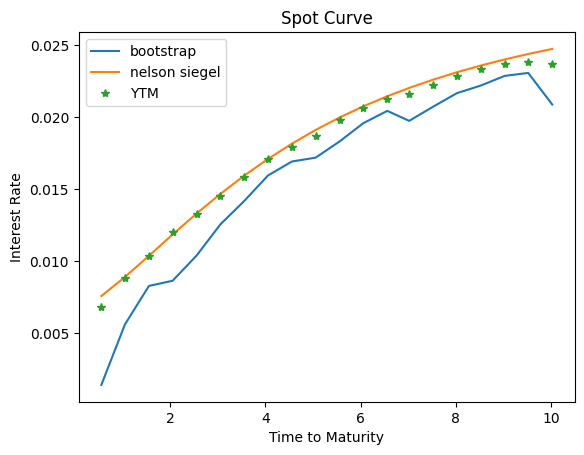

In [23]:
# Plot the Bootstrap and OLS Rates
ax = curves[['bootstrap', 'nelson siegel']].plot(linestyle='-')

# Plot YTM with only markers (no connecting line)
curves['YTM'].plot(ax=ax, marker='*', linestyle='')  

# For legends, the names of the columns from the dataframes
plt.legend(curves)

plt.xlabel('Time to Maturity')
plt.ylabel('Interest Rate')
plt.title('Spot Curve')
plt.show()

### 2.4 (10pts)

Which of the two spot rate curves (bootstrapped or Nelson-Siegel) would be better for...
* pricing the provided sample
* building spot rates out to 30 years
* calculating forward rates

For each of these three questions, be **specific** in your answer.

* pricing the provided sample

Bootstrap is better. Bootsrap will price perfectly in-sample.

* building spot rates out to 30 years

Nelson-Siegel is better. Nelson-Siegel can easily extend to arbitrary maturities, whereas the bootstrap will fail when the time-to-maturity extends past available market data.

* calculating forward rates

Nelson-Siegel is better. Nelson-Siegel will generate smoother forward rates.

### 2.5 (5pts)

Consider the bootstrapped curve and its associated forward curve. (No need to calculate the forward curve.)

Conceptually, do you expect it is higher or lower than the spot-rate curve at
* $T=1$
* $T=10$

Explain.

 The spot curve is increasing if and only if the forward curve is above the spot curve. <br>
 The spot curve is decreasing if and only if the forward curve is below the spot curve.

 At T = 1, the spot curve is increasing. This means that the forward curve is above the spot curve, at T = 1. <br>
 At T = 10, the spot curve is decreasing. This means that the forward curve is below the spot curve, at T = 10. 

### 2.6 (5pts)

Use the bootstrapped spot curve to calculate the forward rate for $T_1=3\to T_2=3.5$.

In [24]:
# Computing the Forward Rate
forward_disc_factor = bs_disc_factor / bs_disc_factor.shift(1)

# Put it on the dataframe
bootstrap_df['Forward Disc Factor'] = forward_disc_factor

# Put the first value as the same as the bootstrap DF
bootstrap_df['Forward Disc Factor'].iloc[0] = bootstrap_df['Bootstrap Discount Factor'].iloc[0]

bootstrap_df.head()

/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_76281/2652443538.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bootstrap_df['Forward Disc Factor'].iloc[0] = bootstrap_df['Bootstrap Discount Factor'].iloc[0]


,Bootstrap Rate,Bootstrap Discount Factor,Forward Disc Factor
Time to Maturity,,,
0.561259,0.001425,0.999201,0.999201
1.056810,0.005623,0.994084,0.994879
1.560575,0.008291,0.987170,0.993045
2.056126,0.008648,0.982413,0.995181
2.559890,0.010396,0.973805,0.991238


In [25]:
# Create a new DataFrame with only the 'Forward Disc Factor' column
forward_df = bootstrap_df[['Forward Disc Factor']]

# Rename the index to 'T'
forward_df.index.name = "T"

forward_df

,Forward Disc Factor
T,
0.561259,0.999201
1.056810,0.994879
1.560575,0.993045
2.056126,0.995181
2.559890,0.991238
3.058179,0.988329
3.561944,0.987988
4.057495,0.985998
4.561259,0.987682


In [26]:
forward_df.index.to_series().diff().mean()

np.float64(0.4978565510284952)

In [27]:
# Computing the Forward Rate
forward_rate = -np.log(forward_df['Forward Disc Factor']) / forward_df.index.to_series().diff().mean()
forward_df['Forward Rate'] = forward_rate
forward_df

/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_76281/3817762261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forward_df['Forward Rate'] = forward_rate


,Forward Disc Factor,Forward Rate
T,,
0.561259,0.999201,0.001606
1.056810,0.994879,0.010313
1.560575,0.993045,0.014018
2.056126,0.995181,0.009704
2.559890,0.991238,0.017677
3.058179,0.988329,0.023580
3.561944,0.987988,0.024274
4.057495,0.985998,0.028324
4.561259,0.987682,0.024896


In [28]:
# Retrieve the Forward Rates
forward_rate_value = forward_df.iloc[6]['Forward Rate'] * 100
print(f'The Forward Rate is {forward_rate_value:.2f}%')

The Forward Rate is 2.43%


***

# 3. Trading the Yield Curve



Use the file, `famabliss_strips_2023-12-29.xlsx` for the following problem.

* The file provides prices for **strips** which are zero-coupon bonds. 
* Assume face value of 100.
* Because these prices are on zero-coupon bonds, they can be interpreted as discount factors, $Z$, directly.

Note that you will make use of only a few rows of the data set.

In [29]:
# Specify the quote date
QUOTE_DATE = '2023-12-29'

# Importing the excel file
filepath_rawdata = f'../data/famabliss_strips_{QUOTE_DATE}.xlsx'
prices = pd.read_excel(filepath_rawdata,sheet_name='prices')
prices.set_index('date',inplace=True)

# Convert index to datetime if not already
prices.index = pd.to_datetime(prices.index)

filtered_px = prices.loc[prices.index >= "2010-01-29"]
filtered_px.head()

,1,2,3,4,5
date,,,,,
2010-01-29,99.688332,98.431098,96.079773,92.897235,88.898332
2010-02-26,99.634036,98.382216,96.005407,92.837117,88.952554
2010-03-31,99.543353,98.011830,95.406463,91.815832,87.855676
2010-04-30,99.586509,98.126680,95.647441,92.229581,88.461054
2010-05-28,99.632358,98.495532,96.383408,93.162552,89.932014


### 1. (10pts)

Set up a trade as of `2010-01-29` to 
* go long 100 million (market value) of the 5-year.
* short the 2-year strips in a quantity that is duration hedged.

List the positions you hold long and short. 
* Assume you are financing the positions directly; no worries about haircuts. 
* Assume there are no market frictions, so you can short securities and immediately receive their market value. 
* (No need to worry about borrowing costs for the short.)

In [30]:
# Inputs
trade_date = "2010-01-29"
long_capital = 100_000_000  # $100 million
price_long = filtered_px.loc[trade_date, 5]
price_short = filtered_px.loc[trade_date, 2]
duration_long = 5
duration_short = 2

# Calculate number of bonds for long position
n_i = long_capital / price_long

# Calculate hedge ratio and number of notes for short position
hedge_ratio = (price_long * duration_long) / (price_short * duration_short)
n_j = -n_i * hedge_ratio

# Calculate total value of the short position
short_position_value = n_j * price_short

# Print results
print(f"Long Position: Number of contracts: {n_i:,.2f}")
print(f"Long Position: Market value: ${long_capital:,.2f}")

print(f"Short Position: Number of contracts: {n_j:,.2f}")
print(f"Short Position: Market value: ${short_position_value:,.2f}")

Long Position: Number of contracts: 1,124,880.49
Long Position: Market value: $100,000,000.00
Short Position: Number of contracts: -2,539,847.73
Short Position: Market value: $-250,000,000.00


### 2. (5pts)
As of `2011-01-31`, assess the pnl on the long, short, and net trade.

In [31]:
trade_date = "2010-01-29"
price_long = filtered_px.loc[trade_date, 5]
price_short = filtered_px.loc[trade_date, 2]

# Position size : Number of security x Price of each security
position_long_1 = n_i * price_long
position_short_1 = n_j * price_short
position_size_1 =  n_i * price_long + n_j * price_short
print(f"For trade date: {trade_date}")
print(f"Long position size: ${position_long_1:,.2f}")
print(f"Short position size: ${position_short_1:,.2f}")
print(f"Total position size: ${position_size_1:,.2f}\n")

trade_date = "2011-01-31"
price_long = filtered_px.loc[trade_date, 5]
price_short = filtered_px.loc[trade_date, 2]

# Position size : Number of security x Price of each security
position_long_2 = n_i * price_long
position_short_2 = n_j * price_short
position_size_2 =  n_i * price_long + n_j * price_short
print(f"For trade date: {trade_date}")
print(f"Long position size: ${position_long_2:,.2f}")
print(f"Short position size: ${position_short_2:,.2f}")
print(f"Total position size: ${position_size_2:,.2f}\n")

pnl_long = position_long_2 - position_long_1 
pnl_short = position_short_2 - position_short_1
pnl_net = pnl_long + pnl_short

print(f"For trade date: {trade_date}")
print(f"PnL - Long Position: ${pnl_long:,.2f}")
print(f"PnL - Short Position: ${pnl_short:,.2f}")
print(f"PnL - Net: ${pnl_net:,.2f}")

For trade date: 2010-01-29
Long position size: $100,000,000.00
Short position size: $-250,000,000.00
Total position size: $-150,000,000.00

For trade date: 2011-01-31
Long position size: $101,930,251.35
Short position size: $-251,260,756.04
Total position size: $-149,330,504.68

For trade date: 2011-01-31
PnL - Long Position: $1,930,251.35
PnL - Short Position: $-1,260,756.04
PnL - Net: $669,495.32


### 3. (10pts)
On `2011-01-31`, roll over the trade.
* close out the short positions
* enter new short positions in 2-year strips that are a duration hedge against your (continuing) long positions.

List the details of your short and long positions in terms of market value and face value of each side of the trade.

In [32]:
# Inputs
# trade_date = "2010-01-29"
trade_date_2 = "2011-01-31"

long_capital = 100_000_000  # $100 million
price_long = filtered_px.loc[trade_date_2, 4] # 5-year turns to 4-year
price_short = filtered_px.loc[trade_date_2, 2]
duration_long = 4
duration_short = 2

# Calculate number of bonds for long position
# n_i = long_capital / price_long # n_i stays the same

# Calculate hedge ratio and number of notes for short position
hedge_ratio = (price_long * duration_long) / (price_short * duration_short)
n_j = -n_i * hedge_ratio

# Calculate total value of the short position
short_position_value = n_j * price_short

# Calculate total value of the long position
long_position_value = n_i * price_long

# Print results
print(f"Long Position: Number of contracts: {n_i:,.2f}")
print(f"Long Position: Market value: ${long_position_value:,.2f}")

print(f"Short Position: Number of contracts: {n_j:,.2f}")
print(f"Short Position: Market value: ${short_position_value:,.2f}")

Long Position: Number of contracts: 1,124,880.49
Long Position: Market value: $106,179,199.31
Short Position: Number of contracts: -2,146,606.59
Short Position: Market value: $-212,358,398.62


### 4. (5pts)
On `2012-01-31`, close out the trade.

Report...
* pnl for the long, short, and net of the trade.

In [33]:
# Inputs
trade_date = "2012-01-31"
price_long = filtered_px.loc[trade_date, 4]
price__short = filtered_px.loc[trade_date, 2]

# Position size : Number of security x Price of each security
position_long_3 = n_i * price_long
position_short_3 = n_j * price__short
position_size_3 =  n_i * price_long + n_j * price__short
print(f"Long position size: ${position_long_3:,.2f}")
print(f"Short position size: ${position_short_3:,.2f}")
print(f"Total position size: ${position_size_3:,.2f}\n")

pnl_long = position_long_3 - long_position_value
pnl_short = position_short_3 - short_position_value
pnl_net = pnl_long + pnl_short

print(f"PnL - Long Position: ${pnl_long:,.2f}")
print(f"PnL - Short Position: ${pnl_short:,.2f}")
print(f"PnL - Net: ${pnl_net:,.2f}")

Long position size: $110,314,479.58
Short position size: $-213,705,902.84
Total position size: $-103,391,423.26

PnL - Long Position: $4,135,280.27
PnL - Short Position: $-1,347,504.22
PnL - Net: $2,787,776.05


### 5. (5pts)
How did this trade do compared to a long-only trade in 5-year notes? Explain.

In [34]:
trade_date = "2010-01-29"
price_long = filtered_px.loc[trade_date, 5]
print(f"Original Price: ${price_long:,.2f}")

trade_date = "2012-01-31"
# The 5-year note becomes a 3-year note after 2 years
price_long_2 = filtered_px.loc[trade_date, 3]
print(f"New Price: ${price_long_2:,.2f}")

# PnL Long-Only = Price Change x Number of Contracts hold
pnl_long_only = (price_long_2 - price_long) * n_i
print(f"PnL - Long Only: ${pnl_long_only:,.2f}")

Original Price: $88.90
New Price: $99.09
PnL - Long Only: $11,463,430.86


This trade doesn't do well compared to a long-only trade on the 5-year note. The Net PnL at the end of our long-short trade is around $3 million. The long-only trade would have yielded around $11 million. 

### 6. (5pts)

Notwithstanding the duration hedge, why was the trade still sensitive to changing levels of the spot rate curve?

Be specific in your answer, and consider which quantitative metric would support your answer.

Because of convexity. We learn that because of convexity, a rate increase won't make a security's price to fall as significant as predicted by the duration formula. Similarly, a rate decrease won't make a security's price to rise as significant as predicted by the duration number. Therefore, even though we have hedged out the duration, this inaccuracy of predicting where a security's price will be due to changes in interest rate will cause some unexpected changes in the securities' values. This will result in a residual PnL for the hedged strategy. 

* The positions have convexity. The long-short trade still has positive convexity. <br>
* The changes to interest rates are not parallel shifts of the spot curve, which means duration is not perfectly hedging even the linear effects.

### 7. (5pts)

Does this trade rely on the Expectations Hypothesis being true or false? How about this type of trade in general?

The expectation hypothesis (EH) states that long-term yields should simply reflect expectations of future short-term rates, meaning that the yield curve shape would not, on average, allow traders to profit from yield differentials.

No, this trade does not depend on the EH. The EH says what will happen on average, not in a given trade.

In general, these types of trades rely on the EH being false, because we are trying to profit from holding higher-yielding security and shorting the lower-yielding security.

### 8. (5pts)

As of `2012-01-31`, is the market environment favorable to this type of long-short trade?

Be specific.

Based on our study of the EH, this environment is not favorable to this trade as of 2012.

The term structure is flat, as seen by the spot rates. We saw evidence that this type of long-short trade tends to do better when the term structure has a strong upward slope.

### 9. (5pts)

As of `2010-01-29`, what is the continuously compounded forward rate from $T_1=2\to T_2=4$?

In [35]:
# Computing the Forward Discount Factor
# From t1 = 1 to t2 = 3
# From t1 = 2 to t2 = 4
forward_disc_factor = filtered_px[[3,4,5]] / filtered_px[[1,2,3]].values

# Add for the 2-year spot rate
forward_disc_factor[2] = filtered_px[2]


forward_disc_factor.head()

,3,4,5,2
date,,,,
2010-01-29,0.963802,0.943779,0.925255,98.431098
2010-02-26,0.963580,0.943637,0.926537,98.382216
2010-03-31,0.958441,0.936783,0.920857,98.011830
2010-04-30,0.960446,0.939903,0.924866,98.126680
2010-05-28,0.967391,0.945856,0.933065,98.495532


In [36]:
forward_rate = -np.log(forward_disc_factor)
forward_rate.head()

,3,4,5,2
date,,,,
2010-01-29,0.036870,0.057863,0.077685,-4.589357
2010-02-26,0.037099,0.058014,0.076301,-4.588860
2010-03-31,0.042447,0.065303,0.082451,-4.585088
2010-04-30,0.040358,0.061978,0.078107,-4.586259
2010-05-28,0.033153,0.055665,0.069280,-4.590011


In [37]:
frate = forward_rate.loc['2010-01-29', 4]
print(f"Forward Rate: {frate*100:,.2f}%")

Forward Rate: 5.79%


### 10. (5pts)

As of `2012-01-31`, is the two-year continuously-compoounded spot rate, $r(0,2)$ higher or lower than the forward rate calculated above for `2010-01-29`?

Is this surprising?

In [38]:
FACE = 100

# log spot rates
spots = -np.log(prices/FACE)/prices.columns
spots.head()

,1,2,3,4,5
date,,,,,
1952-06-30,0.01839,0.019094,0.019751,0.019128,0.020145
1952-07-31,0.019236,0.020247,0.020869,0.020007,0.021402
1952-08-29,0.019613,0.020541,0.021399,0.02045,0.022026
1952-09-30,0.019885,0.020881,0.021495,0.020584,0.02293
1952-10-31,0.019073,0.020544,0.021483,0.021038,0.021685


In [39]:
# Spot Rate for 2012-01-31
spots_2 = spots.loc[spots.index == "2012-01-31"]
spots_2.style.format('{:.2%}').format_index('{:%Y-%m-%d}')

,1,2,3,4,5
date,,,,,
2012-01-31,0.15%,0.22%,0.31%,0.49%,0.73%


The two year continuously compounded spot rate as of 2012-01-31 is 0.22%. This is lower than the forward rate computer earlier of 5.79%. 

This is not a surprise. Had the rate in 2012 been as high as the 2010 spot indicated, the trades above would not have been as profitable. The trades benefited from rates being lower in 2012 than the forwards would have predicted in 2010.

***

# 4. The Swap-Spread

Consider the market data below. 
* It refers to **20-year** T-bonds and swaps.
* Assume the T-bond has exactly 20-years to maturity, with a coupon that exactly matches the YTM below.

In [40]:
summary = pd.DataFrame(index=['YTM','swap rate'],columns = ['Nov 2018','Nov 2023'],dtype=float)
summary.loc['YTM'] = [.031480, .046670]
summary.loc['swap rate'] = [.027639,.039895]
summary.style.format('{:.4%}')

,Nov 2018,Nov 2023
YTM,3.1480%,4.6670%
swap rate,2.7639%,3.9895%


In [41]:
# Extract YTM values
ytm_nov_2018 = summary.loc['YTM', 'Nov 2018']
ytm_nov_2023 = summary.loc['YTM', 'Nov 2023']

# Extract Swap Rate values
swaprate_nov_2018 = summary.loc['swap rate', 'Nov 2018']
swaprate_nov_2023 = summary.loc['swap rate', 'Nov 2023']

maturity_bond = 20
treasury_marketvalue = 100_000_000

In [42]:
ytm_nov_2018 - swaprate_nov_2018

np.float64(0.0038410000000000007)

### 4.1. (5pts)

Consider `Nov 2018`. Suppose you enter into a swap-spread trade.
* You go long \$100 million **market value** of 20-year T-bonds.
* You simultaneously enter a 20-year swap, paying-fixed, with notional of \$100 million.


Report the 
* price of the T-bond in Nov 2018.
* amount of T-bonds purchased, (each face value of 100).

In [43]:
ytm = ytm_nov_2018
coupon_rate = ytm_nov_2018
face_value = 100  # Face value = Par Value
time_to_maturity = 20  # Years to maturity

treasury_price_nov_2018 = price_treasury_ytm(ytm, coupon_rate, face_value, time_to_maturity)
print(f"The price of the Treasury bond is: ${treasury_price_nov_2018:.2f}")

n_bond = treasury_marketvalue / face_value
print(f"Amount of T-bonds purchased: {n_bond:,.2f}")

The price of the Treasury bond is: $100.00
Amount of T-bonds purchased: 1,000,000.00


### 4.2. (5pts)

Report the first cashflow of the trade, in May 2019.

For simplicity, 
* assume the swap pays semiannually, at the same date the T-bond pays coupons.
* the repo rate involved in the trade cancels out with the floating rate of the swap.
* the repo term is semiannually, corresponding to the coupon and swap dates.
* there are not any margin calls or distributions in the discussion below.

If the haircut is 4\% to repo the T-bonds, then what is the May 2019 cashflow as a percentage of the equity capital in the position?

In [44]:
# No need to account for the repo rate or the swap's floating payment, 
# as they both are modeled in this problem with SOFR, and thus net to zero
SOFR = np.nan

face_value = 100 # Units of tens of millions
ytm = ytm_nov_2018
coupon_rate = ytm_nov_2018
swap_rate = swaprate_nov_2018

CF = pd.DataFrame(index=['T bond','Repo','Swap (floating leg)','Swap (fixed leg)'],columns=['May 2019'],dtype=float)

CF.loc['Repo'] = -SOFR # Pay SOFR (floating) as repo rate to borrow cash for buying T-bonds

cashflow_treasury = face_value * coupon_rate /2 # Receive fixed rate coupon payment from Treasuries
CF.loc[['T bond']] = cashflow_treasury

CF.loc['Swap (floating leg)'] = SOFR # Receive floating rate from swap

cashflow_swap_fix = -face_value * swap_rate/2 # Pay fixed rate on swap
CF.loc[['Swap (fixed leg)']] = cashflow_swap_fix

CF.loc['Net Payment'] = CF.sum(axis=0)
CF.style.format('${:,.2f}')

,May 2019
T bond,$1.57
Repo,$nan
Swap (floating leg),$nan
Swap (fixed leg),$-1.38
Net Payment,$0.19


In [45]:
swap_spread = CF.loc['Net Payment', 'May 2019']
swap_spread_dollar = swap_spread * 1_000_000
print(f"Cash flow: ${swap_spread_dollar:,.2f}")

# Equity = Asset * Haircut
haircut = 0.04
equity_treasury = treasury_marketvalue * haircut

print(f"Equity Capital: ${equity_treasury:,.2f}")

# Percent of Equity Capital
percent_of_capital = (swap_spread_dollar / equity_treasury)*100

print(f"Percent of Equity Capital: {percent_of_capital:,.2f}%")


Cash flow: $192,050.00
Equity Capital: $4,000,000.00
Percent of Equity Capital: 4.80%


### 4.3. (5pts)

Report the risk of the trade.
* Duration and dollar duration for the T-bond
* Duration and dollar duration for the swap

Note that you are reporting the usual, Macauley, duration--not the modified duration. 

For each of these duration calculations, use only the YTM and swap rates--no need for a discount curve.

In [46]:
# Treasury Bond
tau = maturity_bond
ytm = ytm_nov_2018
coupon_rate = ytm_nov_2018
freq = 2       # Semi-annual payments

dur_treasury = duration_closed_formula(tau, ytm, coupon_rate, freq=2)
print(f"Duration of the Treasury Bond: {dur_treasury:.4f}")

# Dollar Duration = Duration x Treasury Price (calculated)
dur_dollar_treasury = dur_treasury * treasury_price_nov_2018
print(f"Dollar Duration of the Treasury Bond: ${dur_dollar_treasury:,.4f}")

Duration of the Treasury Bond: 14.9901
Dollar Duration of the Treasury Bond: $1,499.0104


In [47]:
# Fixed Leg of Swap
tau = maturity_bond
swap_rate = swaprate_nov_2018
coupon_rate = None # For fixed leg of swap, think of zero-coupon bond
freq = 2       # Semi-annual payments

dur_swap_fix = duration_closed_formula(tau, swap_rate, coupon_rate, freq=2)
print(f"Duration of the Fixed Leg of the Swap: {dur_swap_fix:.4f}")

# Dollar duration = Duration x Price
# Swaps are combinations of bonds and notes
# Price = 100
dur_dollar_swap_fix = dur_swap_fix * 100
print(f"Dollar Duration of the Fixed Leg of the Swap: ${dur_dollar_swap_fix:,.4f}\n")

dur_swap_float = 0.5 # Semi-annual reset
dur_dollar_swap_float = dur_swap_float * 100

print(f"Duration of the Floating Leg of the Swap: {dur_swap_float}")
print(f"Dollar Duration of the Fixed Leg of the Swap: ${dur_dollar_swap_float:,.4f}")

Duration of the Fixed Leg of the Swap: 15.4965
Dollar Duration of the Fixed Leg of the Swap: $1,549.6528

Duration of the Floating Leg of the Swap: 0.5
Dollar Duration of the Fixed Leg of the Swap: $50.0000


In [48]:
dur_repo = 0.5 # Semi-annual reset
# Borrowed Repo = treasury price * (1-haircut)
repo = treasury_price_nov_2018 * (1 - haircut)
dur_dollar_repo = dur_repo * repo

print(f"Duration of the Repo: {dur_repo}")
print(f"Repo Amount: ${repo:,.4f}")
print(f"Dollar Duration of the Repo: ${dur_dollar_repo:,.4f}")

Duration of the Repo: 0.5
Repo Amount: $96.0000
Dollar Duration of the Repo: $48.0000


In [49]:
tab_net = pd.DataFrame(dtype=float, index=['T repo','swap'], columns=['duration','dollar duration'])
# For T Repo: Treasury Bond (fixed) - Repo (floating)
net_dur_repo = dur_treasury - dur_repo
net_dur_dollar_repo = dur_dollar_treasury - dur_dollar_repo
tab_net.loc['T repo', 'duration'] = net_dur_repo
tab_net.loc['T repo', 'dollar duration'] = net_dur_dollar_repo

# For Swap: Fixed Leg - Floating Leg
net_dur_swap = dur_swap_fix - dur_swap_float
net_dur_dollar_swap = dur_dollar_swap_fix - dur_dollar_swap_float
tab_net.loc['swap', 'duration'] = net_dur_swap
tab_net.loc['swap', 'dollar duration'] = net_dur_dollar_swap

tab_net.loc['net'] = tab_net.loc['T repo'] - tab_net.loc['swap']

tab_net

,duration,dollar duration
T repo,14.490104,1451.010444
swap,14.996528,1499.652807
net,-0.506424,-48.642363


### 4.4. (5pts)

Use **modified** duration to answer the following:

* What is the expected profit and loss if the swap-spread goes to zero?
* What return would this be relative to the initial equity capital to put on the position?

#### Note:
We refer to the spread (swap-rate minus T-bond YTM) going to zero symmetrically (the YTM falls and swap rate rise equally until converging.)

### 4.5. (10pts)

Now it is `Nov 2023`. Use the market quotes to report...
* the value of the long T-bond positions (15 years-to-maturity)
* the value of the paying-fixed swap (15 years-to-expiration)
* the net value of your position and return on your equity capital.

In [50]:
# New Parameters:
ytm_2 = ytm_nov_2023
swap_rate_2 = swaprate_nov_2023

In [51]:
# Pricing Treasuries based on YTM
ytm_2 = ytm_nov_2023 # new YTM
swap_rate_2 = swaprate_nov_2023
coupon_rate = ytm_nov_2018 # old YTM
face_value = 100  # Face value of $100
time_to_maturity = 15  # Years to maturity

treasury_price_nov_2023 = price_treasury_ytm(ytm_2, coupon_rate, face_value, time_to_maturity)
print(f"The new price of the Treasury bond is: ${treasury_price_nov_2023:.2f}")

The new price of the Treasury bond is: $83.74


In [52]:
# Pricing Fixed Leg of the Swap

# Use the new swap rate as the discount rate (YTM) for the new Swap
ytm = swaprate_nov_2023

# Use the old swap rate as the coupon rate for the new Swap
coupon_rate = swaprate_nov_2018 

face_value = 100  # Face value of $100
time_to_maturity = 15  # Years to maturity

fix_leg_price = price_treasury_ytm(ytm, coupon_rate, face_value, time_to_maturity)
print(f"On Nov 2023:")
print(f"Price of the Fixed Leg of the Swap: ${fix_leg_price:.2f}")

par_value = 100
print(f"Price of the Floating Leg of the Swap: ${par_value:.2f}")

# Swap Price = Fixed Leg Price - Floating Leg Price
swap_price_nov_2023 = fix_leg_price - par_value
print(f"Price of the Swap: ${swap_price_nov_2023:.2f}\n")

swap_price_nov_2018 = par_value - par_value
print(f"Price of the Swap on Nov 2018: ${swap_price_nov_2018:.2f}")

On Nov 2023:
Price of the Fixed Leg of the Swap: $86.27
Price of the Floating Leg of the Swap: $100.00
Price of the Swap: $-13.73

Price of the Swap on Nov 2018: $0.00


In [53]:
treasury_position = 100_000_0000
swap_position = 100_000_0000

tprice_new = treasury_price_nov_2023
tprice_old = treasury_price_nov_2018
swapprice_new = swap_price_nov_2023
swapprice_old = swap_price_nov_2018

In [54]:
# Cash Flow Total = Cash Flow per Position x Position size
cashflow_treasury_total = cashflow_treasury * treasury_position
cashflow_swap_total = cashflow_swap_fix * swap_position
cashflow_net = cashflow_treasury_total + cashflow_swap_total

print(f"Cash Flow from Treasury Position: ${cashflow_treasury_total:,.2f}")
print(f"Cash Flow from Swap Position: ${cashflow_swap_total:,.2f}")
print(f"Cash Flow Net: ${cashflow_net:,.2f}\n")

# Capital gains = (New Price - Old Price) x Position Size
capgains_treasury = (tprice_new - tprice_old) * treasury_position
capgains_swap = (swapprice_new - swapprice_old) * swap_position
capgains_net = capgains_treasury + capgains_swap

print(f"Capital Gains from Treasury Position: ${capgains_treasury:,.2f}")
print(f"Capital Gains from Swap Position: ${capgains_swap:,.2f}")
print(f"Capital Gains Net: ${capgains_net:,.2f}\n")

# PnL = Cash Flow Total + Capital Gains
pnl_treasury = cashflow_treasury_total + capgains_treasury
pnl_swap = cashflow_swap_total + capgains_swap
pnl_net = pnl_treasury + pnl_swap

print(f"PnL from Treasury Position: ${pnl_treasury:,.2f}")
print(f"PnL from Swap Position: ${pnl_swap:,.2f}")
print(f"PnL Net: ${pnl_net:,.2f}")


Cash Flow from Treasury Position: $1,574,000,000.00
Cash Flow from Swap Position: $-1,381,950,000.00
Cash Flow Net: $192,050,000.00

Capital Gains from Treasury Position: $-16,255,272,666.85
Capital Gains from Swap Position: $-13,734,460,623.40
Capital Gains Net: $-29,989,733,290.26

PnL from Treasury Position: $-14,681,272,666.85
PnL from Swap Position: $-15,116,410,623.40
PnL Net: $-29,797,683,290.26


In [55]:
# Asset = Old Price x Position Size
asset_treasury = tprice_old * treasury_position
asset_swap = swapprice_old * swap_position
asset_net = asset_treasury + asset_swap

print(f"Asset - Treasuries: ${asset_treasury:,.2f}")
print(f"Asset - Swap: ${asset_swap:,.2f}")
print(f"Asset - Net: ${asset_net:,.2f}\n")

# Equity = Asset * Haircut
haircut = 0.04
equity_treasury = asset_treasury * haircut
equity_swap = asset_swap * haircut
equity_net = equity_treasury + equity_swap

print(f"Equity - Treasuries: ${equity_treasury:,.2f}")
print(f"Equity - Swap: ${equity_swap:,.2f}")
print(f"Equity - Net: ${equity_net:,.2f}\n")

# Return on Equity = (Net PnL / Net asset) x 100
RoE = (pnl_net/equity_net)*100
print(f"Return on Equity: {RoE:,.2f}%")

Asset - Treasuries: $100,000,000,000.00
Asset - Swap: $0.00
Asset - Net: $100,000,000,000.00

Equity - Treasuries: $4,000,000,000.00
Equity - Swap: $0.00
Equity - Net: $4,000,000,000.00

Return on Equity: -744.94%


### 4.6. (5pts)

Assume there are no market frictions, and there is more credit risk in the swap than in the T-bond.

In that case, is the swap-spread trade an arbitrage, a statistically favorable trade, both, or neither? 

Be specific whether your answer is for the long-term or short-term.

In the short term, it is an arbitrage trade because it exploits statistical arbitrage (price differences) that are not supposed to be happening. Swap spreads should either widened or tightened according to the historical mean (what it should be) and there should not be an arbitrage opportunity. However, it is not a statistically favorable trade in the short term because there is no guarantee that in the short term, swap spreads will rever to its mean. If swap spreads behave contradictory to your expectations, your positiions can lose money (-200% or -300%) in the short term.

In the long term, it is still an arbitrage trade (because of the reasons above) but it is now a statistically favorable trade. Why? Because historically speaking, swap spreads revert back to the mean. Price differences in the market converge. However, it can take a long time for markets to become rational and behave according to economic theories. Your positions (if executed properly) will make money, thus it is statistically favorable, but in the long run. 

In the long-term, this is an arbitrage.

If held to maturity, guaranteed to profit as the spread must converge to zero.

In the short-term, there is a statistical trade.

Depends on the spread getting smaller vs larger, based on past data. (And ideally soon!)
No mathematical reason that it needs to converge any time soon.

***